In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_2.csv', header=0, index_col="time") #2, 9, 49, 93, 130
#df = data_preparation(df)
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df = df.dropna(axis='columns')
values = df.values

# specify the number of days and features 
n_input = 7
n_features = df.shape[1]
n_predict = 7

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input, n_predict)
print(reframed.shape)

(1196, 154)


In [5]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_input * n_features
n_predict_obs = n_predict * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_predict_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_predict_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

X, y = values[:, :n_obs], values[:, -n_predict_obs::n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
X = X.reshape((X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(956, 77) 956 (956, 7)
(956, 7, 11) (956, 7) (240, 7, 11) (240, 7)


Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 3s - loss: 0.1738 - accuracy: 0.1413 - val_loss: 0.0910 - val_accuracy: 0.1583
Epoch 2/100
1076/1076 - 0s - loss: 0.0951 - accuracy: 0.1673 - val_loss: 0.0454 - val_accuracy: 0.2250
Epoch 3/100
1076/1076 - 0s - loss: 0.0656 - accuracy: 0.1729 - val_loss: 0.0488 - val_accuracy: 0.2750
Epoch 4/100
1076/1076 - 0s - loss: 0.0564 - accuracy: 0.1933 - val_loss: 0.0472 - val_accuracy: 0.2917
Epoch 5/100
1076/1076 - 0s - loss: 0.0488 - accuracy: 0.2138 - val_loss: 0.0476 - val_accuracy: 0.2917
Epoch 6/100
1076/1076 - 0s - loss: 0.0426 - accuracy: 0.2333 - val_loss: 0.0430 - val_accuracy: 0.3000
Epoch 7/100
1076/1076 - 0s - loss: 0.0380 - accuracy: 0.2407 - val_loss: 0.0396 - val_accuracy: 0.3417
Epoch 8/100
1076/1076 - 0s - loss: 0.0336 - accuracy: 0.2900 - val_loss: 0.0360 - val_accuracy: 0.3750
Epoch 9/100
1076/1076 - 0s - loss: 0.0297 - accuracy: 0.2974 - val_loss: 0.0328 - val_accuracy: 0.3750
Epoch 10/100
1076/1076 - 0

Epoch 80/100
1076/1076 - 0s - loss: 0.0067 - accuracy: 0.2742 - val_loss: 0.0024 - val_accuracy: 0.2667
Epoch 81/100
1076/1076 - 0s - loss: 0.0069 - accuracy: 0.2751 - val_loss: 0.0024 - val_accuracy: 0.2583
Epoch 82/100
1076/1076 - 0s - loss: 0.0063 - accuracy: 0.2686 - val_loss: 0.0024 - val_accuracy: 0.2583
Epoch 83/100
1076/1076 - 0s - loss: 0.0064 - accuracy: 0.2955 - val_loss: 0.0025 - val_accuracy: 0.2583
Epoch 84/100
1076/1076 - 0s - loss: 0.0069 - accuracy: 0.2667 - val_loss: 0.0024 - val_accuracy: 0.2583
Epoch 85/100
1076/1076 - 0s - loss: 0.0068 - accuracy: 0.2556 - val_loss: 0.0024 - val_accuracy: 0.2750
Epoch 86/100
1076/1076 - 0s - loss: 0.0060 - accuracy: 0.2807 - val_loss: 0.0022 - val_accuracy: 0.2417
Epoch 87/100
1076/1076 - 0s - loss: 0.0063 - accuracy: 0.2593 - val_loss: 0.0023 - val_accuracy: 0.2667
Epoch 88/100
1076/1076 - 0s - loss: 0.0065 - accuracy: 0.2788 - val_loss: 0.0022 - val_accuracy: 0.2333
Epoch 89/100
1076/1076 - 0s - loss: 0.0062 - accuracy: 0.2519 - 

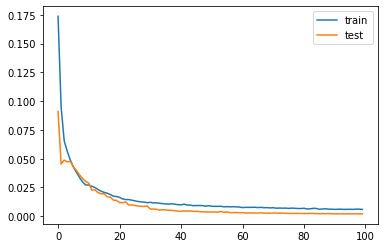

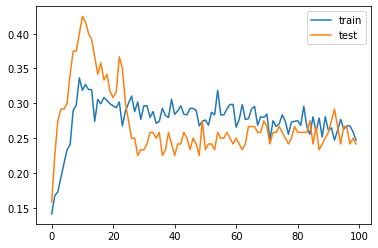

Test loss:0.25%
Test score:35.42%
Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 0s - loss: 0.0059 - accuracy: 0.2612 - val_loss: 0.0013 - val_accuracy: 0.2833
Epoch 2/100
1076/1076 - 0s - loss: 0.0059 - accuracy: 0.2333 - val_loss: 0.0014 - val_accuracy: 0.2667
Epoch 3/100
1076/1076 - 0s - loss: 0.0061 - accuracy: 0.2584 - val_loss: 0.0013 - val_accuracy: 0.2750
Epoch 4/100
1076/1076 - 0s - loss: 0.0056 - accuracy: 0.2593 - val_loss: 0.0016 - val_accuracy: 0.3000
Epoch 5/100
1076/1076 - 0s - loss: 0.0057 - accuracy: 0.2658 - val_loss: 0.0014 - val_accuracy: 0.3167
Epoch 6/100
1076/1076 - 0s - loss: 0.0058 - accuracy: 0.2593 - val_loss: 0.0015 - val_accuracy: 0.2750
Epoch 7/100
1076/1076 - 0s - loss: 0.0059 - accuracy: 0.2639 - val_loss: 0.0016 - val_accuracy: 0.3167
Epoch 8/100
1076/1076 - 0s - loss: 0.0055 - accuracy: 0.2770 - val_loss: 0.0017 - val_accuracy: 0.3167
Epoch 9/100
1076/1076 - 0s - loss: 0.0055 - accuracy: 0.2667 - val_loss: 0.0015 - val_accuracy:

1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2556 - val_loss: 0.0015 - val_accuracy: 0.3083
Epoch 80/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2537 - val_loss: 0.0018 - val_accuracy: 0.3167
Epoch 81/100
1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2556 - val_loss: 0.0013 - val_accuracy: 0.3000
Epoch 82/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2788 - val_loss: 0.0014 - val_accuracy: 0.3250
Epoch 83/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2565 - val_loss: 0.0014 - val_accuracy: 0.3000
Epoch 84/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2770 - val_loss: 0.0013 - val_accuracy: 0.3333
Epoch 85/100
1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2788 - val_loss: 0.0014 - val_accuracy: 0.3000
Epoch 86/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2825 - val_loss: 0.0013 - val_accuracy: 0.3333
Epoch 87/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2732 - val_loss: 0.0015 - val_accuracy: 0.3583
Epoch 88/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2770 - val_loss: 0.0

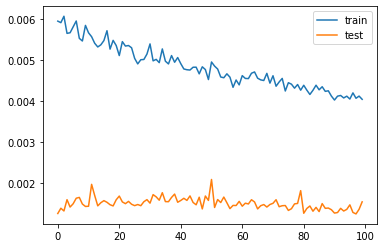

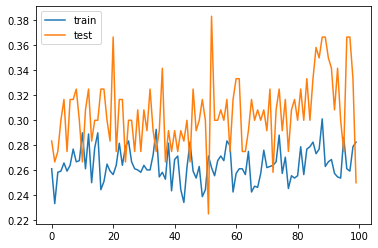

Test loss:0.23%
Test score:40.00%
Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2900 - val_loss: 0.0019 - val_accuracy: 0.3667
Epoch 2/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2435 - val_loss: 0.0018 - val_accuracy: 0.3333
Epoch 3/100
1076/1076 - 0s - loss: 0.0040 - accuracy: 0.2667 - val_loss: 0.0019 - val_accuracy: 0.3417
Epoch 4/100
1076/1076 - 0s - loss: 0.0041 - accuracy: 0.2528 - val_loss: 0.0026 - val_accuracy: 0.3333
Epoch 5/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2612 - val_loss: 0.0029 - val_accuracy: 0.3083
Epoch 6/100
1076/1076 - 0s - loss: 0.0041 - accuracy: 0.2946 - val_loss: 0.0024 - val_accuracy: 0.3167
Epoch 7/100
1076/1076 - 0s - loss: 0.0041 - accuracy: 0.2686 - val_loss: 0.0027 - val_accuracy: 0.3167
Epoch 8/100
1076/1076 - 0s - loss: 0.0041 - accuracy: 0.2500 - val_loss: 0.0035 - val_accuracy: 0.2583
Epoch 9/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2760 - val_loss: 0.0046 - val_accuracy:

1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2742 - val_loss: 0.0029 - val_accuracy: 0.2917
Epoch 80/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2639 - val_loss: 0.0031 - val_accuracy: 0.2667
Epoch 81/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2695 - val_loss: 0.0032 - val_accuracy: 0.2917
Epoch 82/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2918 - val_loss: 0.0030 - val_accuracy: 0.3000
Epoch 83/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2667 - val_loss: 0.0033 - val_accuracy: 0.2667
Epoch 84/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2370 - val_loss: 0.0044 - val_accuracy: 0.2917
Epoch 85/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2574 - val_loss: 0.0048 - val_accuracy: 0.3167
Epoch 86/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2621 - val_loss: 0.0036 - val_accuracy: 0.3500
Epoch 87/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2742 - val_loss: 0.0035 - val_accuracy: 0.3000
Epoch 88/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2574 - val_loss: 0.0

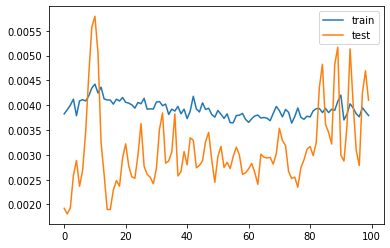

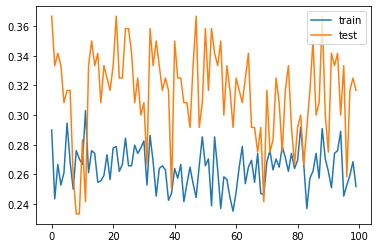

Test loss:0.19%
Test score:37.08%
Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2686 - val_loss: 0.0014 - val_accuracy: 0.3000
Epoch 2/100
1076/1076 - 0s - loss: 0.0040 - accuracy: 0.2351 - val_loss: 0.0012 - val_accuracy: 0.3000
Epoch 3/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2574 - val_loss: 0.0011 - val_accuracy: 0.2917
Epoch 4/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2770 - val_loss: 0.0011 - val_accuracy: 0.3000
Epoch 5/100
1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2667 - val_loss: 0.0010 - val_accuracy: 0.3167
Epoch 6/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2463 - val_loss: 0.0011 - val_accuracy: 0.3000
Epoch 7/100
1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2760 - val_loss: 9.1837e-04 - val_accuracy: 0.2917
Epoch 8/100
1076/1076 - 0s - loss: 0.0041 - accuracy: 0.2546 - val_loss: 9.6297e-04 - val_accuracy: 0.3333
Epoch 9/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2853 - val_loss: 9.0879e-04 - v

Epoch 79/100
1076/1076 - 0s - loss: 0.0036 - accuracy: 0.2639 - val_loss: 0.0013 - val_accuracy: 0.3083
Epoch 80/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2658 - val_loss: 0.0011 - val_accuracy: 0.2833
Epoch 81/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2704 - val_loss: 0.0012 - val_accuracy: 0.2583
Epoch 82/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2621 - val_loss: 0.0016 - val_accuracy: 0.3000
Epoch 83/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2667 - val_loss: 0.0014 - val_accuracy: 0.2583
Epoch 84/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2677 - val_loss: 0.0014 - val_accuracy: 0.2917
Epoch 85/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2546 - val_loss: 0.0013 - val_accuracy: 0.3000
Epoch 86/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2732 - val_loss: 0.0013 - val_accuracy: 0.2917
Epoch 87/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2537 - val_loss: 0.0012 - val_accuracy: 0.3167
Epoch 88/100
1076/1076 - 0s - loss: 0.0035 - accuracy: 0.2649 - 

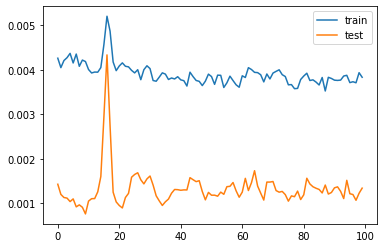

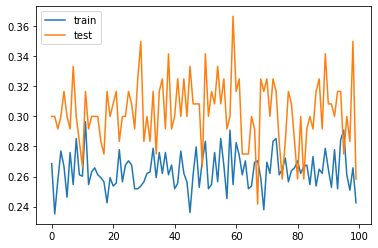

Test loss:0.22%
Test score:32.92%
Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2760 - val_loss: 0.0016 - val_accuracy: 0.2083
Epoch 2/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2742 - val_loss: 0.0015 - val_accuracy: 0.2583
Epoch 3/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2695 - val_loss: 0.0012 - val_accuracy: 0.2417
Epoch 4/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2602 - val_loss: 0.0011 - val_accuracy: 0.1833
Epoch 5/100
1076/1076 - 0s - loss: 0.0042 - accuracy: 0.2760 - val_loss: 0.0011 - val_accuracy: 0.1750
Epoch 6/100
1076/1076 - 0s - loss: 0.0043 - accuracy: 0.2844 - val_loss: 0.0010 - val_accuracy: 0.1917
Epoch 7/100
1076/1076 - 0s - loss: 0.0045 - accuracy: 0.2779 - val_loss: 0.0011 - val_accuracy: 0.2167
Epoch 8/100
1076/1076 - 0s - loss: 0.0045 - accuracy: 0.2844 - val_loss: 0.0012 - val_accuracy: 0.2250
Epoch 9/100
1076/1076 - 0s - loss: 0.0044 - accuracy: 0.2546 - val_loss: 8.0265e-04 - val_accur

Epoch 77/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2556 - val_loss: 6.6426e-04 - val_accuracy: 0.2000
Epoch 78/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2686 - val_loss: 3.7642e-04 - val_accuracy: 0.2250
Epoch 79/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2593 - val_loss: 4.2838e-04 - val_accuracy: 0.1667
Epoch 80/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2677 - val_loss: 6.2801e-04 - val_accuracy: 0.2333
Epoch 81/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2686 - val_loss: 6.5165e-04 - val_accuracy: 0.2167
Epoch 82/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2602 - val_loss: 5.3058e-04 - val_accuracy: 0.2000
Epoch 83/100
1076/1076 - 0s - loss: 0.0036 - accuracy: 0.2807 - val_loss: 7.4294e-04 - val_accuracy: 0.2083
Epoch 84/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2491 - val_loss: 0.0011 - val_accuracy: 0.2083
Epoch 85/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2649 - val_loss: 0.0011 - val_accuracy: 0.2000
Epoch 86/100
1076/1076 - 0s - loss: 

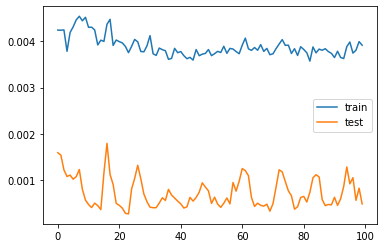

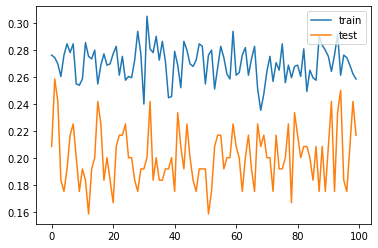

Test loss:0.17%
Test score:37.92%
Train on 1076 samples, validate on 120 samples
Epoch 1/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2500 - val_loss: 9.0150e-04 - val_accuracy: 0.3833
Epoch 2/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2928 - val_loss: 6.0493e-04 - val_accuracy: 0.3333
Epoch 3/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2463 - val_loss: 6.1769e-04 - val_accuracy: 0.3083
Epoch 4/100
1076/1076 - 0s - loss: 0.0036 - accuracy: 0.2807 - val_loss: 6.8128e-04 - val_accuracy: 0.3083
Epoch 5/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2667 - val_loss: 7.2672e-04 - val_accuracy: 0.2500
Epoch 6/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2835 - val_loss: 7.4448e-04 - val_accuracy: 0.2833
Epoch 7/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2491 - val_loss: 6.0361e-04 - val_accuracy: 0.2750
Epoch 8/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2686 - val_loss: 5.8200e-04 - val_accuracy: 0.3000
Epoch 9/100
1076/1076 - 0s - loss: 0.0036 - accuracy: 0.2667 - 

Epoch 77/100
1076/1076 - 0s - loss: 0.0039 - accuracy: 0.2565 - val_loss: 8.3375e-04 - val_accuracy: 0.3167
Epoch 78/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2305 - val_loss: 7.9946e-04 - val_accuracy: 0.3333
Epoch 79/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2639 - val_loss: 6.9099e-04 - val_accuracy: 0.3083
Epoch 80/100
1076/1076 - 0s - loss: 0.0036 - accuracy: 0.2574 - val_loss: 7.6628e-04 - val_accuracy: 0.2917
Epoch 81/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2509 - val_loss: 8.5021e-04 - val_accuracy: 0.2917
Epoch 82/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2388 - val_loss: 8.7939e-04 - val_accuracy: 0.2750
Epoch 83/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2463 - val_loss: 9.4291e-04 - val_accuracy: 0.3083
Epoch 84/100
1076/1076 - 0s - loss: 0.0038 - accuracy: 0.2472 - val_loss: 9.3467e-04 - val_accuracy: 0.3750
Epoch 85/100
1076/1076 - 0s - loss: 0.0037 - accuracy: 0.2565 - val_loss: 7.8004e-04 - val_accuracy: 0.3667
Epoch 86/100
1076/1076 - 0s 

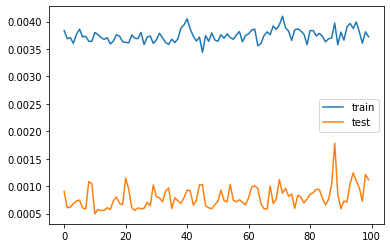

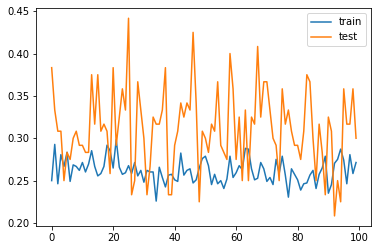

Test loss:0.21%
Test score:35.00%
Train on 1077 samples, validate on 119 samples
Epoch 1/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2693 - val_loss: 0.0056 - val_accuracy: 0.4790
Epoch 2/100
1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2340 - val_loss: 0.0055 - val_accuracy: 0.5210
Epoch 3/100
1077/1077 - 0s - loss: 0.0036 - accuracy: 0.2739 - val_loss: 0.0057 - val_accuracy: 0.5546
Epoch 4/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2312 - val_loss: 0.0064 - val_accuracy: 0.4706
Epoch 5/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2470 - val_loss: 0.0059 - val_accuracy: 0.4958
Epoch 6/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2618 - val_loss: 0.0059 - val_accuracy: 0.4706
Epoch 7/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2358 - val_loss: 0.0053 - val_accuracy: 0.5210
Epoch 8/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2702 - val_loss: 0.0053 - val_accuracy: 0.5126
Epoch 9/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2498 - val_loss: 0.0056 - val_accuracy:

Epoch 80/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2470 - val_loss: 0.0055 - val_accuracy: 0.4874
Epoch 81/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2479 - val_loss: 0.0055 - val_accuracy: 0.4370
Epoch 82/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2637 - val_loss: 0.0058 - val_accuracy: 0.3866
Epoch 83/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2535 - val_loss: 0.0057 - val_accuracy: 0.4874
Epoch 84/100
1077/1077 - 0s - loss: 0.0030 - accuracy: 0.2433 - val_loss: 0.0058 - val_accuracy: 0.5042
Epoch 85/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2526 - val_loss: 0.0056 - val_accuracy: 0.4370
Epoch 86/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2488 - val_loss: 0.0059 - val_accuracy: 0.4874
Epoch 87/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2479 - val_loss: 0.0057 - val_accuracy: 0.4790
Epoch 88/100
1077/1077 - 0s - loss: 0.0029 - accuracy: 0.2507 - val_loss: 0.0055 - val_accuracy: 0.5294
Epoch 89/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2461 - 

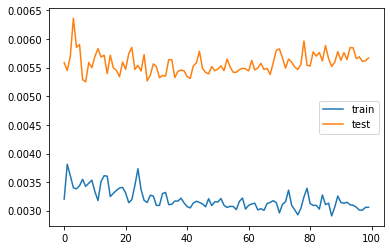

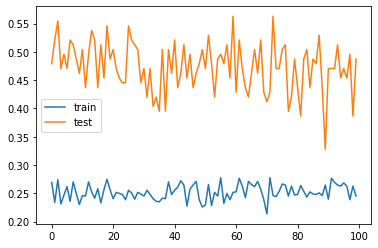

Test loss:0.16%
Test score:39.58%
Train on 1077 samples, validate on 119 samples
Epoch 1/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2488 - val_loss: 0.0012 - val_accuracy: 0.4538
Epoch 2/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2628 - val_loss: 0.0012 - val_accuracy: 0.4622
Epoch 3/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2628 - val_loss: 0.0016 - val_accuracy: 0.4706
Epoch 4/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2535 - val_loss: 0.0014 - val_accuracy: 0.4622
Epoch 5/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2823 - val_loss: 0.0019 - val_accuracy: 0.4202
Epoch 6/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2906 - val_loss: 0.0014 - val_accuracy: 0.3866
Epoch 7/100
1077/1077 - 1s - loss: 0.0035 - accuracy: 0.2711 - val_loss: 0.0018 - val_accuracy: 0.4538
Epoch 8/100
1077/1077 - 1s - loss: 0.0035 - accuracy: 0.2572 - val_loss: 0.0013 - val_accuracy: 0.4286
Epoch 9/100
1077/1077 - 1s - loss: 0.0035 - accuracy: 0.2553 - val_loss: 0.0010 - val_accuracy:

1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2321 - val_loss: 0.0011 - val_accuracy: 0.3277
Epoch 80/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2786 - val_loss: 0.0011 - val_accuracy: 0.3697
Epoch 81/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2674 - val_loss: 0.0014 - val_accuracy: 0.3361
Epoch 82/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2683 - val_loss: 0.0014 - val_accuracy: 0.3697
Epoch 83/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2711 - val_loss: 0.0014 - val_accuracy: 0.3782
Epoch 84/100
1077/1077 - 0s - loss: 0.0036 - accuracy: 0.2451 - val_loss: 0.0015 - val_accuracy: 0.3361
Epoch 85/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2498 - val_loss: 0.0013 - val_accuracy: 0.3613
Epoch 86/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2516 - val_loss: 0.0013 - val_accuracy: 0.4370
Epoch 87/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2878 - val_loss: 0.0014 - val_accuracy: 0.4286
Epoch 88/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2609 - val_loss: 0.0

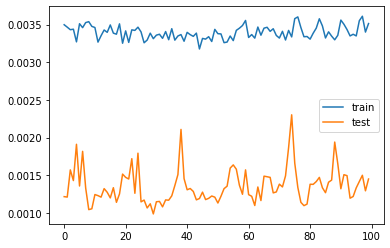

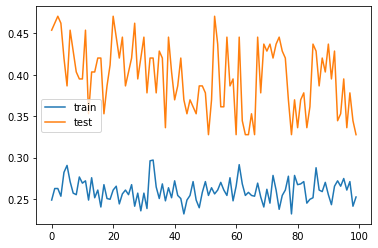

Test loss:0.15%
Test score:35.83%
Train on 1077 samples, validate on 119 samples
Epoch 1/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2711 - val_loss: 0.0017 - val_accuracy: 0.3277
Epoch 2/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2526 - val_loss: 0.0022 - val_accuracy: 0.3445
Epoch 3/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2628 - val_loss: 0.0023 - val_accuracy: 0.3277
Epoch 4/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2535 - val_loss: 0.0023 - val_accuracy: 0.3277
Epoch 5/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2507 - val_loss: 0.0020 - val_accuracy: 0.3529
Epoch 6/100
1077/1077 - 0s - loss: 0.0034 - accuracy: 0.2609 - val_loss: 0.0022 - val_accuracy: 0.3025
Epoch 7/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2553 - val_loss: 0.0022 - val_accuracy: 0.3529
Epoch 8/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2609 - val_loss: 0.0020 - val_accuracy: 0.3445
Epoch 9/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2479 - val_loss: 0.0021 - val_accuracy:

1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2776 - val_loss: 0.0024 - val_accuracy: 0.3361
Epoch 80/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2758 - val_loss: 0.0025 - val_accuracy: 0.2941
Epoch 81/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2683 - val_loss: 0.0026 - val_accuracy: 0.3109
Epoch 82/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2553 - val_loss: 0.0025 - val_accuracy: 0.2773
Epoch 83/100
1077/1077 - 0s - loss: 0.0031 - accuracy: 0.2618 - val_loss: 0.0024 - val_accuracy: 0.3109
Epoch 84/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2423 - val_loss: 0.0023 - val_accuracy: 0.3445
Epoch 85/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2628 - val_loss: 0.0025 - val_accuracy: 0.3613
Epoch 86/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2479 - val_loss: 0.0022 - val_accuracy: 0.3277
Epoch 87/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2693 - val_loss: 0.0023 - val_accuracy: 0.3782
Epoch 88/100
1077/1077 - 0s - loss: 0.0032 - accuracy: 0.2591 - val_loss: 0.0

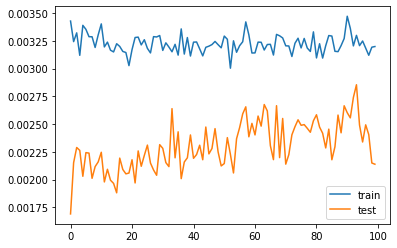

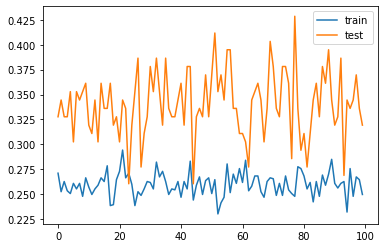

Test loss:0.15%
Test score:35.42%
Train on 1077 samples, validate on 119 samples
Epoch 1/100
1077/1077 - 0s - loss: 0.0036 - accuracy: 0.2702 - val_loss: 9.7122e-04 - val_accuracy: 0.4286
Epoch 2/100
1077/1077 - 0s - loss: 0.0036 - accuracy: 0.2349 - val_loss: 0.0020 - val_accuracy: 0.4118
Epoch 3/100
1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2526 - val_loss: 0.0032 - val_accuracy: 0.4706
Epoch 4/100
1077/1077 - 0s - loss: 0.0046 - accuracy: 0.2693 - val_loss: 0.0035 - val_accuracy: 0.4118
Epoch 5/100
1077/1077 - 0s - loss: 0.0050 - accuracy: 0.2442 - val_loss: 0.0035 - val_accuracy: 0.3613
Epoch 6/100
1077/1077 - 0s - loss: 0.0045 - accuracy: 0.2256 - val_loss: 0.0016 - val_accuracy: 0.4622
Epoch 7/100
1077/1077 - 0s - loss: 0.0039 - accuracy: 0.2507 - val_loss: 0.0014 - val_accuracy: 0.3866
Epoch 8/100
1077/1077 - 0s - loss: 0.0042 - accuracy: 0.2609 - val_loss: 0.0014 - val_accuracy: 0.3782
Epoch 9/100
1077/1077 - 0s - loss: 0.0039 - accuracy: 0.2721 - val_loss: 0.0016 - val_accur

1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2442 - val_loss: 0.0024 - val_accuracy: 0.3109
Epoch 80/100
1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2563 - val_loss: 0.0026 - val_accuracy: 0.3361
Epoch 81/100
1077/1077 - 0s - loss: 0.0037 - accuracy: 0.2488 - val_loss: 0.0016 - val_accuracy: 0.3361
Epoch 82/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2618 - val_loss: 0.0014 - val_accuracy: 0.3866
Epoch 83/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2804 - val_loss: 0.0017 - val_accuracy: 0.3697
Epoch 84/100
1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2479 - val_loss: 0.0025 - val_accuracy: 0.3950
Epoch 85/100
1077/1077 - 0s - loss: 0.0041 - accuracy: 0.2581 - val_loss: 0.0026 - val_accuracy: 0.3866
Epoch 86/100
1077/1077 - 0s - loss: 0.0038 - accuracy: 0.2618 - val_loss: 0.0014 - val_accuracy: 0.3697
Epoch 87/100
1077/1077 - 0s - loss: 0.0033 - accuracy: 0.2665 - val_loss: 0.0012 - val_accuracy: 0.3697
Epoch 88/100
1077/1077 - 0s - loss: 0.0035 - accuracy: 0.2609 - val_loss: 0.0

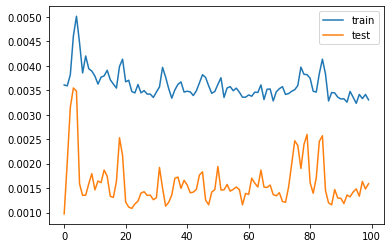

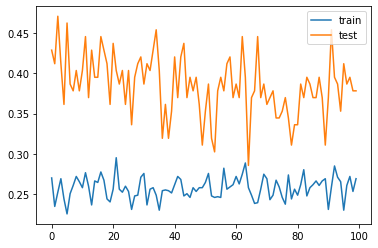

Test loss:0.16%
Test score:37.50%


In [28]:
# design LSTM Model
model = Sequential()

model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(train_X.shape[1], train_X.shape[2]) ))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(n_predict, kernel_initializer='lecun_uniform', activation='relu'))

optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

num_splits = 10

# k-fold cross validation
kf = KFold(n_splits=num_splits)
kf.get_n_splits(X)
KFold(n_splits=num_splits, random_state=None, shuffle=False)

# store score & loss for each fold
score_arr = []
loss_arr = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit Model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    # plot loss history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # plot loss history
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()
        
    # Score model
    test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
    loss, score = model.evaluate(test_X, test_y, verbose=0)
    print('Test loss:%.2f%%' % (loss * 100))
    print('Test score:%.2f%%' % (score * 100))
    
    loss_arr.append(loss)
    score_arr.append(score)

In [38]:
# summarize k-fold results
for i in range(len(score_arr)):
    print('K-Fold {}: Loss:{:.4f}, Score:{:.3f}'.format(i+1, loss_arr[i], score_arr[i] * 100))

K-Fold 1: Loss:0.0025, Score:35.417
K-Fold 2: Loss:0.0023, Score:40.000
K-Fold 3: Loss:0.0019, Score:37.083
K-Fold 4: Loss:0.0022, Score:32.917
K-Fold 5: Loss:0.0017, Score:37.917
K-Fold 6: Loss:0.0021, Score:35.000
K-Fold 7: Loss:0.0016, Score:39.583
K-Fold 8: Loss:0.0015, Score:35.833
K-Fold 9: Loss:0.0015, Score:35.417
K-Fold 10: Loss:0.0016, Score:37.500


In [22]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))

print(yhat.shape)
print(test_X[:, -(n_features-1):].shape)

pred_arr = np.empty((test_X.shape[0], 1))
actual_arr = np.empty((test_X.shape[0], 1))

for i in range(0, yhat.shape[1]):
    # invert scaling for forecast
    yhat_col = yhat[:, i].reshape(len(yhat[:, i]), 1)    
    inv_yhat = concatenate((yhat_col, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    pred_arr = np.append(pred_arr, inv_yhat, axis=1)    
pred_arr = pred_arr[:,1:]

for i in range(0, test_y.shape[1]):
    # invert scaling for actual
    test_y_col = test_y[:, i].reshape(len(test_y[:, i]), 1)
    inv_y = concatenate((test_y_col, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    inv_y = inv_y.reshape(len(inv_y), 1)
    actual_arr = np.append(actual_arr, inv_y, axis=1)
actual_arr = actual_arr[:,1:]      

print("\n######  RMSE #######\n")

rmse_arr = []
# calculate RMSE
for i in range(0, actual_arr.shape[1]):
    rmse = sqrt(mean_squared_error(actual_arr[:, i], pred_arr[:, i]))
    rmse_arr.append(rmse)
    print('t+{} RMSE: {:.3f}'.format(i+1, rmse))
print('Avg. RMSE: {:.3f}'.format(np.mean(rmse_arr)))
    
print("\n######  MAE  #######\n")
    
mae_arr = []
# calculate MAE
for i in range(0, actual_arr.shape[1]):
    mae = mean_absolute_error(actual_arr[:, i], pred_arr[:, i])
    mae_arr.append(mae)
    print('t+{} MAE: {:.3f}'.format(i+1, mae))
print('Avg. MAE: {:.3f}'.format(np.mean(mae_arr)))

(240, 7)
(240, 10)

######  RMSE #######

t+1 RMSE: 1243.633
t+2 RMSE: 1554.772
t+3 RMSE: 1888.579
t+4 RMSE: 2068.283
t+5 RMSE: 2247.027
t+6 RMSE: 2291.800
t+7 RMSE: 2389.552
Avg. RMSE: 1954.807

######  MAE  #######

t+1 MAE: 929.948
t+2 MAE: 1119.309
t+3 MAE: 1372.717
t+4 MAE: 1488.773
t+5 MAE: 1577.708
t+6 MAE: 1592.872
t+7 MAE: 1606.439
Avg. MAE: 1383.967


In [23]:
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))

inv_yhat = pred_arr[:, 0].reshape(len(pred_arr), 1)
inv_y = actual_arr[:, 0].reshape(len(actual_arr), 1)

print(inv_yhat.shape)
print(inv_y.shape)

# print predicted vs expected
num_days = test_y.shape[0]
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        if score > 0:
            accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("Avg. Accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

(240, 1)
(240, 1)
Day=1, Expected=52428.00, Predicted=52207.59, Accuracy=99.58%
Day=2, Expected=50566.00, Predicted=50201.06, Accuracy=99.28%
Day=3, Expected=25610.00, Predicted=25927.14, Accuracy=98.78%
Day=4, Expected=26822.00, Predicted=26975.75, Accuracy=99.43%
Day=5, Expected=52320.00, Predicted=51681.02, Accuracy=98.78%
Day=6, Expected=53457.00, Predicted=53167.58, Accuracy=99.46%
Day=7, Expected=53142.00, Predicted=52641.59, Accuracy=99.06%
Day=8, Expected=53303.00, Predicted=52776.88, Accuracy=99.01%
Day=9, Expected=50991.00, Predicted=50319.57, Accuracy=98.68%
Day=10, Expected=25619.00, Predicted=26010.93, Accuracy=98.49%
Day=11, Expected=26898.00, Predicted=27335.40, Accuracy=98.40%
Day=12, Expected=52101.00, Predicted=51529.54, Accuracy=98.90%
Day=13, Expected=53526.00, Predicted=52720.32, Accuracy=98.49%
Day=14, Expected=53516.00, Predicted=52882.13, Accuracy=98.82%
Day=15, Expected=53233.00, Predicted=53475.42, Accuracy=99.55%
Day=16, Expected=51024.00, Predicted=49964.60,

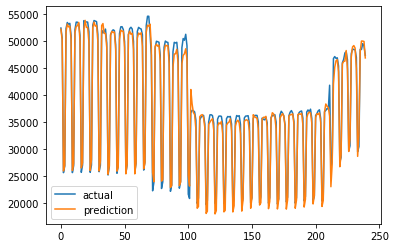

In [9]:
# plot actual vs prediction (All Test Data)
num_days = test_y.shape[0]
pyplot.plot(list(inv_y[:num_days]), label='actual')
pyplot.plot(inv_yhat[:num_days], label='prediction')
pyplot.legend()
pyplot.show()

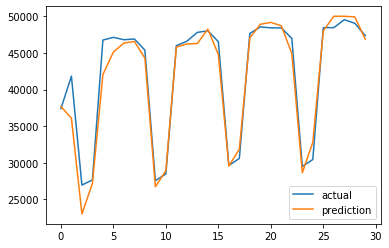

In [10]:
# plot actual vs prediction (Last 30 days)
num_days = 30
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

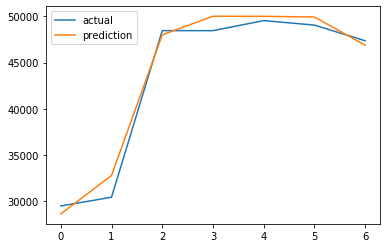

In [11]:
# plot actual vs prediction (Last 7 days)
num_days = 7
pyplot.plot(list(inv_y[-num_days:]), label='actual')
pyplot.plot(inv_yhat[-num_days:], label='prediction')
pyplot.legend()
pyplot.show()

In [12]:
# Predictions Numeric
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
prediction = model.predict(test_X[-1:])
print(prediction.shape)

new_pred_arr = []
for i in range(0, prediction.shape[1]):
    test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
    inv_pred = concatenate(([[prediction[0][i]]], test_X[:prediction.shape[0], -(n_features-1):]), axis=1)
    inv_pred = inv_pred.reshape(1, inv_pred.shape[1])
    inv_pred = scaler.inverse_transform(inv_pred)
    inv_pred = inv_pred[:,0]
    new_pred_arr.append(inv_pred[0])
print(new_pred_arr)

(1, 7)
[46888.45, 28990.68, 28019.562, 46591.74, 46802.457, 46258.84, 47584.69]


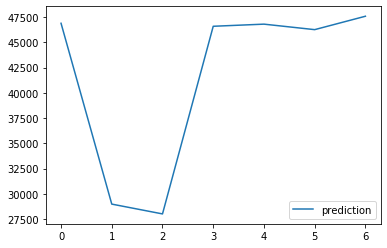

In [13]:
# plot prediction
pyplot.plot(new_pred_arr, label='prediction')
pyplot.legend()
pyplot.show()